# Fraudulent Energy Client Detection

The Tunisian Company of Electricity and Gas (STEG) is public and non-administrative. It is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of **200 million** Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Using the client’s billing history, the challenge aims to detect and recognize clients involved in fraudulent activities.
The findings will enhance the company’s revenues and reduce the losses caused by such fraudulent activities.


In [3]:
#@title Import revelant modules and install Facets
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

This first step aims to understand, clear, sort, and extract important features from the data provided.

We want to answer the following questions:
1. What is the rate of fraudulent clients in the dataset?
2. How are the fraudulent clients distributed across regions/ districts?
3. What period did the most Fraudulent clients join the company?
4. What variables/combination of variables can be used to predict if a client is fraudulent or not?

The data provided by STEG is composed of two files. The first one is comprised of client data, and the second one contains billing history since 2005. 

* Client:

	- Client_id: Unique id for client
	- District: District where the client is
	- Client_catg: Category client belongs to
	- Region: Area where the client is
	- Creation_date: Date client joined
	- Target: fraud:1 , not fraud: 0

* Invoice data

	- Client_id: Unique id for the client
	- Invoice_date: Date of the invoice
	- Tarif_type: Type of tax
	- Counter_number:
	- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
	- Counter_code:
	- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows 		something wrong, the agent gives a bad score)
	- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
	- Consommation_level_1: Consumption_level_1
	- Consommation_level_2: Consumption_level_2
	- Consommation_level_3: Consumption_level_3
	- Consommation_level_4: Consumption_level_4
	- Old_index: Old index
	- New_index: New index
	- Months_number: Month number
	- Counter_type: Type of counter

In [89]:
client_df = pd.read_csv("./data/train/client_train.csv")
invoice_df = pd.read_csv("./data/train/invoice_train.csv")

/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
client_df.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [4]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
disrict          135493 non-null int64
client_id        135493 non-null object
client_catg      135493 non-null int64
region           135493 non-null int64
creation_date    135493 non-null object
target           135493 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


All the columns have 0 Nan values. All types are as expected, except for the creation_date column that needs to be transformed into the datetime. 

In [5]:
client_df.describe()

,disrict,client_catg,region,target
count,135493.0,135493.0,135493.0,135493.0
mean,63.5,11.5,206.2,0.1
std,3.4,4.4,104.2,0.2
min,60.0,11.0,101.0,0.0
25%,62.0,11.0,103.0,0.0
50%,62.0,11.0,107.0,0.0
75%,69.0,11.0,307.0,0.0
max,69.0,51.0,399.0,1.0


In [6]:
def plt_stats(df, col):
    """
    plots the value_counts of a pd.DataFrame's column
    :param df: pd.DataFrame of data
    :param col: column of interest
    """
    figure(figsize=(20,5))
    plt.title(f'Number of clients per {col}')
    df[col].value_counts(ascending=True).plot(kind='barh')
    plt.ylabel(col)
    plt.xlabel('Count')
    plt.show()

### 1. What is the rate of fraudulent clients in the dataset?

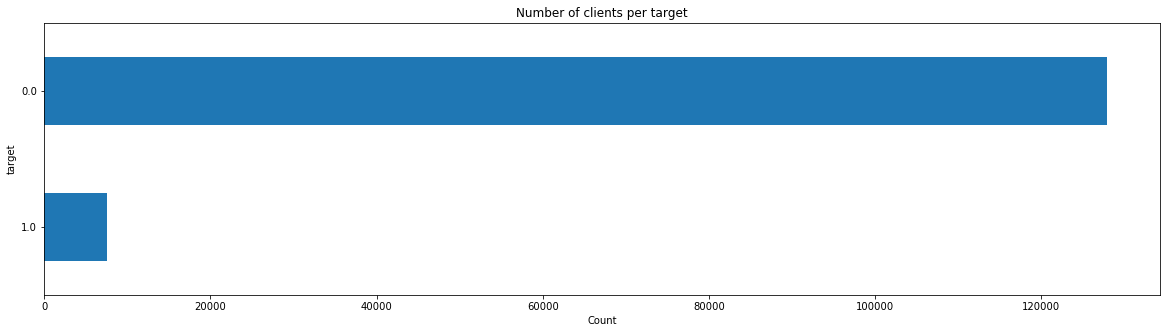

The pourcentage of fraudulent clients is:0.05584052312665599


In [7]:
plt_stats(client_df, col='target')
print(f'The pourcentage of fraudulent clients is:{client_df["target"].mean()}')

The first observation is that the dataset is unbalanced and there could be possibility of bias where the pourcentage of Fraudulent clients is limited to a 5\%.

## 2. How are the fraudulent clients distributed cross regions/ districts?

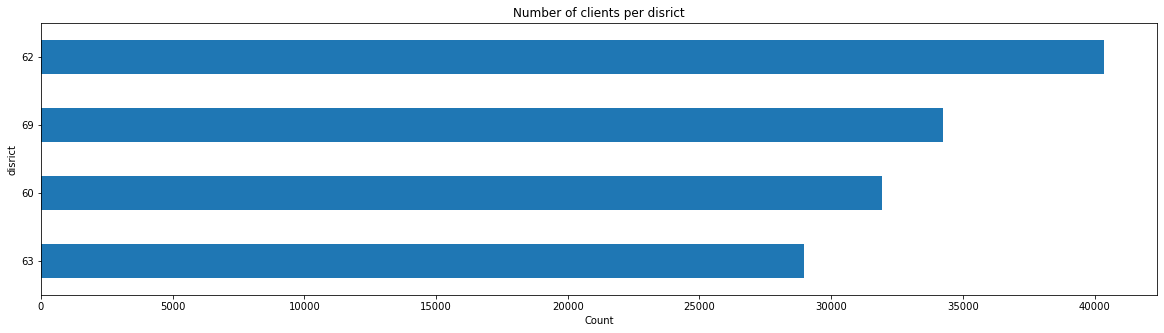

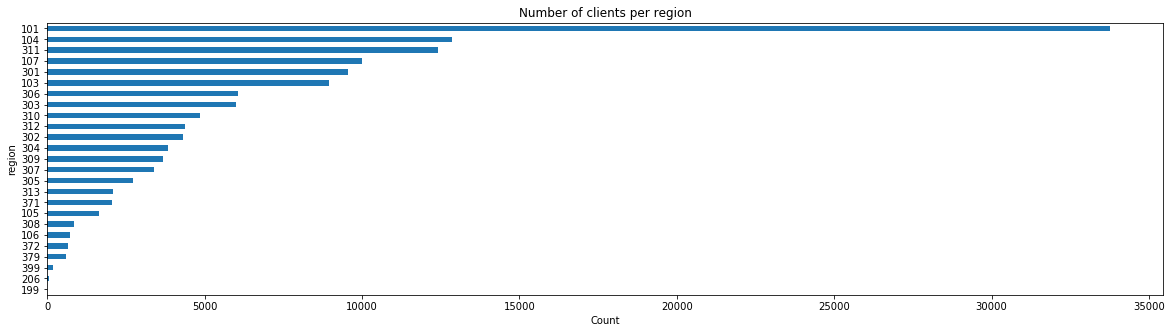

In [8]:
plt_stats(client_df, col='disrict')
plt_stats(client_df, col='region')

The clients are distributed more or less homogeneously across districts, but this is not the case of the distribution across regions. The clients from this dataset are centred in some regions more than others. Nonetheless, it would be more interesting to look at the rate of fraudulent clients per region. 

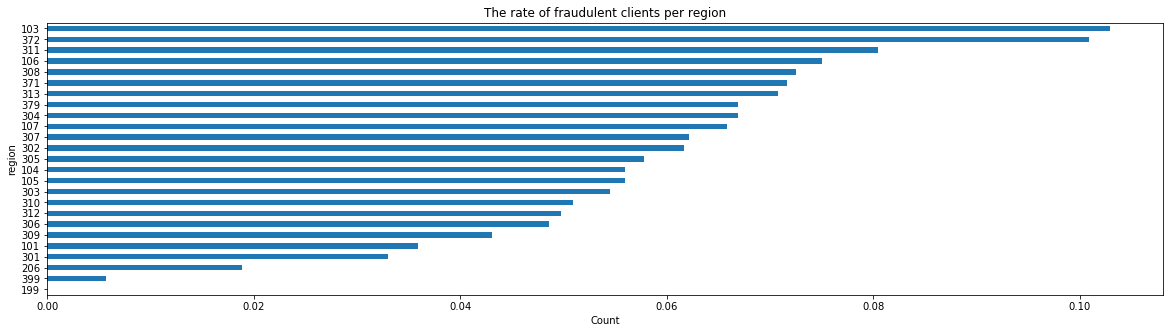

In [103]:
figure(figsize=(20,5))
plt.title('The rate of fraudulent clients per region')
client_df.groupby('region').mean()['target'].sort_values().plot(kind='barh')
plt.ylabel('region')
plt.xlabel('Count')
plt.show()

The last plot indicates that the region is essential for predicting fraudulent activities. The clients of some regions are more likely to be fraudulent than others.

Text(0.5, 1.0, 'The distribution of Faudulent clients per region')

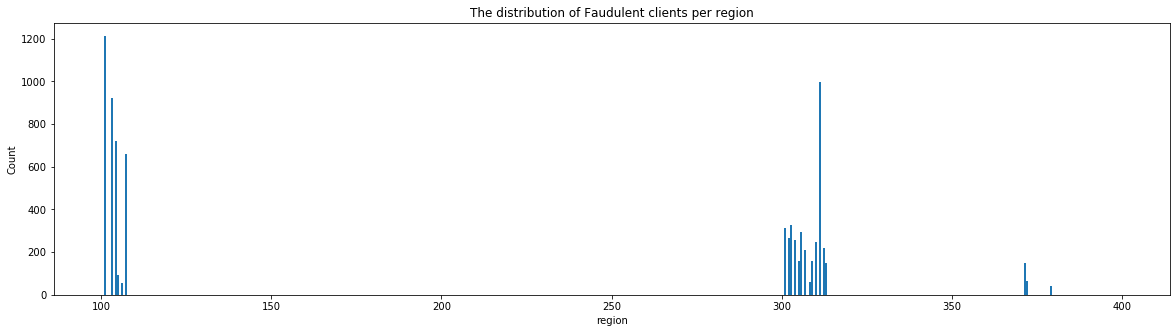

In [281]:
figure(figsize=(20,5))
plt.hist(client_df.loc[client_df['target']==1,'region'], bins=500)
plt.xlabel('region')
plt.ylabel('Count')
plt.title('The distribution of Faudulent clients per region')

## 3. What is the period where the most Fraudulent clients joined the company?

Text(0.5, 1.0, 'Number of fraudulent clients joining the company')

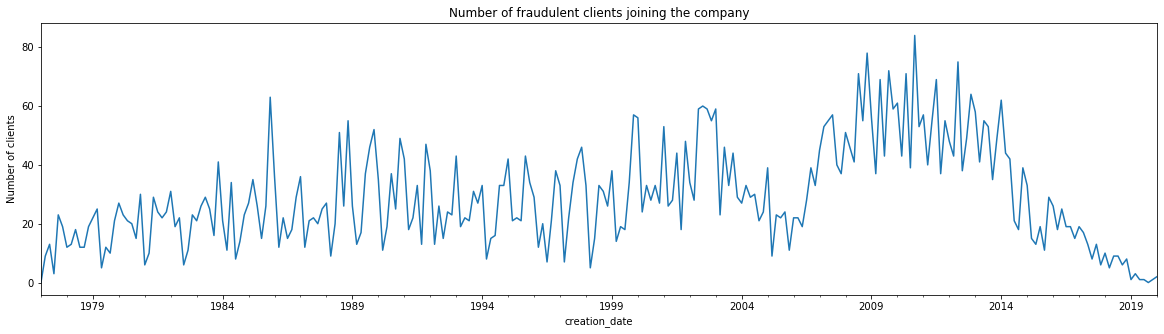

In [282]:
client_df['creation_date'] = pd.to_datetime(client_df['creation_date'])
figure(figsize=(20,5))
client_df.groupby('creation_date').sum().resample('2M').sum()['target'].plot()
plt.ylabel('Date joining the company')
plt.ylabel('Number of clients')
plt.title('Number of fraudulent clients joining the company')

The plot shows that before 2006, the number of fraudulent clients joining the company was more or less steady. 
A peak in the number of fraudulent clients joining is evident around 2011 when the revolution of Tunisia occurred, taking advantage of the political crisis. However, starting from 2014, the number of fraudulent clients joining the company decreased. 

## 3. What are the best predictors for a fraudulent client?

In [283]:
invoice_df.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [284]:
invoice_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
client_id               object
invoice_date            object
tarif_type              int64
counter_number          int64
counter_statue          object
counter_code            int64
reading_remarque        int64
counter_coefficient     int64
consommation_level_1    int64
consommation_level_2    int64
consommation_level_3    int64
consommation_level_4    int64
old_index               int64
new_index               int64
months_number           int64
counter_type            object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [285]:
invoice_df.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0
mean,20.1,123058699065.2,172.5,7.3,1.0,411.0,109.3,20.3,52.9,17767.0,18349.7,44.8
std,13.5,1657267274261.9,133.9,1.6,0.3,757.3,1220.1,157.4,875.5,40366.9,40953.2,3128.3
min,8.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,11.0,121108.0,5.0,6.0,1.0,79.0,0.0,0.0,0.0,1791.0,2056.0,4.0
50%,11.0,494561.0,203.0,8.0,1.0,274.0,0.0,0.0,0.0,7690.0,8192.0,4.0
75%,40.0,1115161.0,207.0,9.0,1.0,600.0,0.0,0.0,0.0,21660.0,22343.0,4.0
max,45.0,27981145458733.0,600.0,413.0,50.0,999910.0,999073.0,64492.0,547946.0,2800280.0,2870972.0,636624.0


In [62]:
df = pd.DataFrame(invoice_df.nunique())
df[df.values.reshape(-1)<40]

,0
tarif_type,17
counter_statue,16
reading_remarque,8
counter_coefficient,16
counter_type,2


In [17]:
assert invoice_df.counter_number.nunique() >= invoice_df.client_id.nunique()

In [18]:
invoice_df.tarif_type.unique()

array([11, 40, 15, 10, 12, 14, 13, 45, 29,  9, 30,  8, 21, 42, 27, 18, 24])

In [19]:
invoice_df.counter_statue.unique() # need to be cleaned, values should be 0-5 according to the meta-data file

array([0, 1, 5, 4, 3, 2, 769, '0', '5', '1', '4', 'A', 618, 269375, 46,
       420], dtype=object)

In [20]:
invoice_df.counter_coefficient.unique()

array([ 1,  3,  0, 10,  4, 33, 50, 20,  2,  6, 40,  9, 30,  5, 11,  8])

In [21]:
invoice_df.counter_type.unique() # need to be mapped to abinary variable

array(['ELEC', 'GAZ'], dtype=object)

In [23]:
invoice_df.counter_statue.unique()

array([0, 1, 5, 4, 3, 2, 769, '0', '5', '1', '4', 'A', 618, 269375, 46,
       420], dtype=object)

The above list is the list of categorical columns. The aggregation of these columns is thus a bit tricky. We will only consider the counter_type as a dummy variable. The other variables are considered ints since their values are highly unbalanced.

In [64]:
def clean_clients(clients):
    """
    cleans the DataFrame of the clients
    :param clients: pd.DataFrame of clients
    :return: pd.DataFrame of clients
    """
    # changing the type of categorical columns
    clients['client_catg'] = clients['client_catg'].astype('category')
    clients['disrict'] = clients['disrict'].astype('category')
    clients['region'] = clients['region'].astype('category')
    # Creating the group regions
    clients['region_group'] = clients['region'].apply(lambda x: 100 if x<100 else 390 if x>390 else 300 if x>300 else 200)
    clients['region_group'] = clients['region_group'].astype('category')
    # Deriving information from the creation time (when the client joined)
    clients['creation_date'] = pd.to_datetime(clients['creation_date'])
    clients['join_time'] = (2019 - clients['creation_date'].dt.year)*12 - clients['creation_date'].dt.month
    clients['join_period'] = (2006 - clients['creation_date'].dt.year)
    clients = clients.drop(['creation_date'], axis=1)
    
    return clients

In [65]:
cleaned_client_df = clean_clients(client_df)

In [66]:
cleaned_client_df.dtypes

disrict         category
client_id         object
client_catg     category
region          category
target           float64
region_group    category
join_time          int64
dtype: object

In [67]:
def clean_invoices(invoices):
    """
    cleans the DataFrame of the clients
    :param invoices: a pd.DataFrame of invocies of the clients
    :return: pd.DataFrame
    """
    # Cleaning the statue values [0-5]
    invoices['counter_statue'] = invoices['counter_statue'].map({
        0:0,1:1,2:2,3:3,4:4,5:5,769:5,'0':0,'5':5,'1':1,'4':4,'A':0,618:5,269375:5,46:5,420:5
    })
    # Deriving information form the invoice dates
    invoices['invoice_date'] = pd.to_datetime(invoices['invoice_date'], dayfirst=True)
    invoices['invoice_month'] = invoices['invoice_date'].dt.month
    invoices['invoice_year'] = invoices['invoice_date'].dt.year
    invoices['is_weekday'] = ((pd.DatetimeIndex(invoices.invoice_date).dayofweek) // 5 == 1).astype(float)
    invoices = invoices.drop(['invoice_date'], axis=1)
    # Getting the power consumption of the meter
    invoices['delta_index'] = invoices['new_index'] - invoices['old_index']
    # Getting the sum of the 4 consumption levels
    invoices['total_consumption'] = invoices[['consommation_level_1',
                                             'consommation_level_2',
                                             'consommation_level_3',
                                             'consommation_level_4']].sum(axis=1)
    # Checking if numbers of the meter and the invoice are identical
    invoices['is_energy_equal'] = (invoices['total_consumption'] == invoices['delta_index'])
    # Turn the counter type into dummy columns
    invoices = pd.get_dummies(invoices, columns=[ 'counter_type'])
    
    return invoices

In [68]:
cleaned_invoices = clean_invoices(invoice_df)

In [16]:
cleaned_invoices.describe()

,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,invoice_month,invoice_year,is_weekday,delta_index,total_consumption,counter_type_ELEC,counter_type_GAZ
count,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0,4476749.0
mean,20.1,123058699065.2,0.0,172.5,7.3,1.0,411.0,109.3,20.3,52.9,17767.0,18349.7,44.8,6.3,2012.7,0.1,582.7,593.5,0.7,0.3
std,13.5,1657267274261.9,0.4,133.9,1.6,0.3,757.3,1220.1,157.4,875.5,40366.9,40953.2,3128.3,3.4,4.1,0.3,4609.4,1775.2,0.5,0.5
min,8.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1977.0,0.0,-999096.0,0.0,0.0,0.0
25%,11.0,121108.0,0.0,5.0,6.0,1.0,79.0,0.0,0.0,0.0,1791.0,2056.0,4.0,3.0,2010.0,0.0,79.0,80.0,0.0,0.0
50%,11.0,494561.0,0.0,203.0,8.0,1.0,274.0,0.0,0.0,0.0,7690.0,8192.0,4.0,6.0,2013.0,0.0,309.0,309.0,1.0,0.0
75%,40.0,1115161.0,0.0,207.0,9.0,1.0,600.0,0.0,0.0,0.0,21660.0,22343.0,4.0,9.0,2016.0,0.0,656.0,657.0,1.0,1.0
max,45.0,27981145458733.0,5.0,600.0,413.0,50.0,999910.0,999073.0,64492.0,547946.0,2800280.0,2870972.0,636624.0,12.0,2019.0,1.0,633228.0,999910.0,1.0,1.0


In [10]:
assert 'client_id' in cleaned_invoices.columns

In [69]:
rename_cols = lambda cols,prefix: [f'{col}_{prefix}' for col in cols]

def join_data(clients, invoice):
    """
    aggregate the invoices of each client and link them to the client
    the aggregation is done using the sum for dummy columns and the
    standard measures of spread for the other columns
    :param clients: pd.DataFrame of clients
    :param invoice: pd.dataFrame of invoices
    :return: a pd.DataFrame of clients and their invoices
    """
    # list of columns that we want to aggregate with a sum
    cols_grp_sum = ['is_weekday', 'is_energy_equal', 'counter_type_ELEC','counter_type_GAZ','client_id' ]
    invoice_agg = invoice[cols_grp_sum].groupby('client_id').sum()
    # droping the already aggregated columns
    invoice = invoice.drop(list(set(cols_grp_sum)- set(['client_id']) ), axis=1)

    invoice_max = invoice.groupby('client_id').max()
    invoice_max.columns = rename_cols(invoice_max.columns, 'max')
    
    invoice_min = invoice.groupby('client_id').min() 
    invoice_min.columns = rename_cols(invoice_min.columns, 'min')
    
    invoice_median = invoice.groupby('client_id').median()
    invoice_median.columns = rename_cols(invoice_median.columns, 'median')
    
    invoice_q25 =  invoice.groupby('client_id').quantile(.25)
    invoice_q25.columns = rename_cols(invoice_q25.columns, 'q25')
    
    invoice_q75 =  invoice.groupby('client_id').quantile(.75)
    invoice_q75.columns = rename_cols(invoice_q75.columns, 'q75')

    invoice_std = invoice.groupby('client_id').std()
    invoice_std.columns = rename_cols(invoice_std.columns, 'std')
    
    invoice_mean = invoice.groupby('client_id').mean()
    invoice_mean.columns = rename_cols(invoice_mean.columns, 'mean')

    invoice_summary = pd.concat([invoice_agg, invoice_max, invoice_min,
                                 invoice_median, 
                                 invoice_q25, invoice_q75,
                                invoice_std, invoice_mean], axis=1).reset_index()
 

    return clients.merge(invoice_summary, on='client_id')


In [70]:
train_data = join_data(cleaned_client_df, cleaned_invoices)

In [71]:
def add_extra_features(df):
    """
    Adds the range and the inter-quartile measures to the features
    :param df:
    :return:
    """
    cols = df.columns[df.dtypes==int]
    for col in cols:
        original_col = col.split('_')
        if len(original_col) == 2 and col!='join_time':
            print(original_col)
            original_col = original_col[0]
            df[f'{original_col}_range'] =  df[f'{original_col}_max'] - df[f'{original_col}_min']
            df[f'{original_col}_iqr'] =  df[f'{original_col}_q75'] - df[f'{original_col}_q25']
    return df

train_data = add_extra_features(train_data)
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
target,135493.0,0.1,0.2,0.0,0.0,0.0,0.0,1.0
join_time,135493.0,38.5,138.5,-168.0,-76.0,3.0,143.0,347.0
tarif_type_max,135493.0,24.3,14.5,10.0,11.0,11.0,40.0,45.0
counter_number_max,135493.0,1053178796983.8,4838268103410.5,0.0,344197.0,846413.0,4903468.0,27981145458733.0
counter_statue_max,135493.0,0.8,1.6,0.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...
months_number_mean,135493.0,33.0,2745.1,1.0,4.0,4.2,4.7,602244.8
invoice_month_mean,135493.0,6.3,1.6,1.0,5.2,6.2,7.4,12.0
invoice_year_mean,135493.0,2012.4,4.9,1977.0,2011.6,2012.7,2015.3,2019.0
delta_index_mean,135493.0,625.3,3359.8,-498591.5,227.7,389.0,635.5,596828.7


In [72]:
# Dropping the columns that are null most of the time
useless_col = train_data.columns[(train_data == 0).astype(int).sum(axis=0) / train_data.shape[0] >.98]
useless_col

Index(['counter_statue_min', 'consommation_level_3_min',
       'consommation_level_4_min', 'counter_statue_median',
       'consommation_level_4_median', 'counter_statue_q25',
       'consommation_level_3_q25', 'consommation_level_4_q25'],
      dtype='object')

In [73]:
train_data = train_data.drop(useless_col, axis=1)

## Modelling

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
import lightgbm
from optuna import Trial
import optuna
import gc

from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier

In [76]:
X, y = train_data.drop(['client_id','target'], axis=1), train_data['target']
assert 'target' not in X.columns

In [25]:
X.describe().T.to_csv('./data/X_train.csv')

In [77]:
client_df = pd.read_csv("./data/test/client_test.csv")
invoice_df = pd.read_csv("./data/test/invoice_test.csv")

cleaned_invoices = clean_invoices(invoice_df)
cleaned_clients= clean_clients(client_df)

test_data = join_data(cleaned_clients, cleaned_invoices).drop(['counter_statue_min', 'consommation_level_3_min',
       'consommation_level_4_min', 'counter_statue_median',
       'consommation_level_4_median', 'counter_statue_q25',
       'consommation_level_3_q25', 'consommation_level_4_q25'], axis=1)


In [78]:
X_test = test_data.drop(['client_id'],axis=1)

In [87]:
%%time
seed= 42
model = LGBMClassifier(random_state=seed, n_estimators=10000,num_leaves=362, max_depth=124,
                           learning_rate=0.008, min_split_gain=0.001,
                           feature_fraction=0.8, bagging_freq=8)

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
res=[]
local_probs=pd.DataFrame()
probs = pd.DataFrame()

for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
    X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
    model.fit(X_train, y_train,
                  eval_set=[(X_valid, y_valid)],
                  early_stopping_rounds=30, verbose=False)
        
    preds = model.predict_proba(X_valid)
    oof_predict = model.predict_proba(X_test)
    local_probs['fold_%i'%i] = oof_predict[:,1]
    res.append(roc_auc_score(y_valid, preds[:,1]))
 
print('ROC AUC:', round(np.mean(res), 6))   
local_probs['res'] = local_probs.mean(axis=1)
probs['target'] = local_probs['res']
submission = pd.DataFrame({
            'client_id': test_data['client_id'],
            'target': probs['target']
    })
submission.to_csv('Samplesubmission.csv', index=False)

/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of

[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8


/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/hafsa/anaconda3/envs/nilmtk-env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


ROC AUC: 0.888086
CPU times: user 20min 36s, sys: 7.46 s, total: 20min 43s
Wall time: 1min 45s


## Submission Results

The results of the submission are quite good according to the [leaderboard](https://zindi.africa/competitions/ai-hack-tunisia-4-predictive-analytics-challenge-1/leaderboard). We scored in the third place. Further optimisation fo the hyper-parameters can improve the predictions.


![Results](./results.png)